<a href="https://colab.research.google.com/github/djhsgfjk/collab/blob/main/Lab_5_%D0%92%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_ORB_%D0%A0%D0%B5%D0%B0%D0%BB%D0%B8%D0%B7%D0%BE%D0%B2%D0%B0%D1%82%D1%8C_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B4%D0%B5%D1%82%D0%B5%D0%BA%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F_%D0%B8_%D0%BE%D0%BF%D0%B8%D1%81%D0%B0%D0%BD%D0%B8%D1%8F_%D0%BE%D1%81%D0%BE%D0%B1%D1%8B%D1%85_%D1%82%D0%BE%D1%87%D0%B5%D0%BA_ORB_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

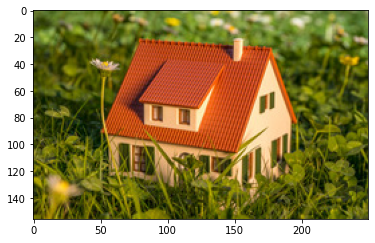

In [2]:
import numpy as np
from PIL import Image
from pylab import *

image=np.array(Image.open('/house.jpg'), dtype=int)
figure()
imshow(image)
show()

In [3]:
w = image.shape[0]
h = image.shape[1]
print(w, h)

156 250


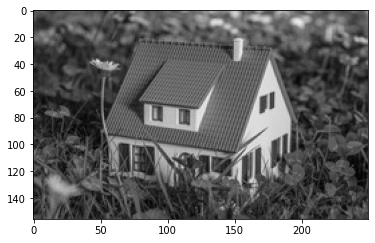

In [4]:
halftoneImage = np.zeros((w,h), dtype=int)
for i in range(w):
    for j in range(h):
        halftoneImage[i][j] = mean(image[i,j,:])
figure()
imshow(halftoneImage, cmap='gray', vmin=0, vmax=255)
show()

# 1. Детектирование особых точек 

Детектирование особых точек на основе алгоритма FAST 

In [5]:
def FAST(image, n, t):
  if n < 6 or n > 16:
    return

  w = image.shape[0]
  h = image.shape[1]

  features = []
  for i in range(3, w-3):
    for j in range(3, h-3):
      p = image[i, j]
      B1 = np.concatenate((image[i:i+2, j-3], image[i+2, j-2], image[i+3, j-1:j+2], image[i+2, j+2], image[i:i+2, j+3]), axis=None)
      B2 = np.concatenate((image[i+3, j:j+2], image[i+2, j+2], image[i-1:i+2, j+3], image[i-2, j+2], image[i-3, j:j+2]), axis=None)
      B =  np.concatenate((image[i-1:i+2, j-3], image[i+2, j-2], image[i+3, j-1:j+2], image[i+2, j+2], image[i-1:i+2, j+3], image[i-2, j+2], image[i-3, j-1:j+2], image[i-2, j-2]), axis=None)
      count = 0
      if (all(q > p+t for q in B1) or all(q > p+t for q in B2)):
        for q in np.concatenate((B, B), axis=None):
          if q > p+t:
            count += 1
          else:
            count = 0
          if count >= n:
            features.append((i, j))
            break
      elif (all(q < p-t for q in B1) or all(q < p-t for q in B2)):
        for q in np.concatenate((B, B), axis=None):
          if q < p-t:
            count += 1
          else:
            count = 0
          if count >= n:
            features.append((i, j))
            break
  return features

In [6]:
F = FAST(halftoneImage, 12, 40)
print(F)

[(18, 228), (19, 228), (19, 229), (24, 97), (26, 127), (61, 178), (61, 179), (62, 177), (62, 178), (62, 179), (63, 178), (63, 179), (64, 173), (65, 172), (71, 177), (71, 178), (72, 177), (72, 178), (72, 179), (73, 177), (73, 178), (75, 170), (76, 170), (76, 171), (77, 170), (81, 94), (88, 173), (88, 174), (89, 172), (90, 171), (91, 169), (91, 194), (92, 168), (92, 188), (93, 167), (93, 187), (93, 188), (94, 187), (94, 188), (95, 188), (96, 183), (101, 16), (101, 75), (103, 168), (103, 169), (104, 167), (104, 168), (105, 168), (105, 193), (106, 150), (107, 113), (107, 162), (110, 105), (110, 106), (111, 106), (111, 182), (112, 146), (113, 146), (115, 12), (115, 103), (115, 179), (116, 173), (116, 179), (117, 178), (118, 55), (120, 130), (120, 146), (120, 152), (123, 48), (125, 68), (142, 62), (147, 245), (152, 25)]


In [7]:
len(F)

73

Полученные по алгоритму FAST точки фильтруем по критерию угловых точек Харриса. 

In [8]:
def build_W(sigma2):
  const1 = 2*sigma2
  const2 = 2*np.pi*sigma2

  G = np.zeros((5, 5), dtype=np.float64)

  for i in range(5):
    for j in range(5):
      G[i, j] = np.power(np.e, -((i-3)**2 + (j-3)**2)/const1)/const2

  G /= np.sum(G)
  return G 

In [9]:
W = build_W(100)
print(W)

[[0.03766047 0.03861385 0.03919742 0.0393939  0.03919742]
 [0.03861385 0.03959136 0.04018971 0.04039116 0.04018971]
 [0.03919742 0.04018971 0.0407971  0.04100159 0.0407971 ]
 [0.0393939  0.04039116 0.04100159 0.04120711 0.04100159]
 [0.03919742 0.04018971 0.0407971  0.04100159 0.0407971 ]]


In [10]:
def get_gradient(image):
  width = image.shape[0]
  height = image.shape[1]

  imageCopy = np.zeros((width+1, height+1), dtype=int)

  for i in range(width):
    for j in range(height):
      imageCopy[i+1, j+1] = image[i, j]

  gradient = np.zeros((width+1, height+1, 2), dtype=float)

  for i in range(1, width):
    for j in range(1, height):
      gradient[i, j, 0] = (imageCopy[i+1, j]-imageCopy[i-1, j] + imageCopy[i+1, j-1]-imageCopy[i-1, j-1] + imageCopy[i+1, j+1]-imageCopy[i-1, j+1])/6
      gradient[i, j, 1] = (imageCopy[i, j+1]-imageCopy[i, j-1] + imageCopy[i-1, j+1]-imageCopy[i-1, j-1] + imageCopy[i+1, j+1]-imageCopy[i+1, j-1])/6

  return gradient[1:width+1, 1:height+1, :]

In [11]:
grad = get_gradient(halftoneImage)
print(grad)

[[[ 30.16666667  30.66666667]
  [ 45.33333333  -0.16666667]
  [ 45.33333333   2.        ]
  ...
  [ 54.83333333  10.66666667]
  [ 63.5         15.83333333]
  [  0.           0.        ]]

 [[ -3.16666667  45.        ]
  [ -5.16666667  -0.5       ]
  [ -6.66666667   1.83333333]
  ...
  [ -5.          14.16666667]
  [ -7.83333333  20.83333333]
  [  0.           0.        ]]

 [[  0.16666667  44.16666667]
  [ -0.5         -1.33333333]
  [ -2.          -0.83333333]
  ...
  [ -7.5         12.        ]
  [-10.83333333  16.83333333]
  [  0.           0.        ]]

 ...

 [[ 14.66666667  35.66666667]
  [ 20.33333333   0.83333333]
  [ 14.66666667   0.33333333]
  ...
  [ -0.83333333  -0.5       ]
  [  0.66666667   0.5       ]
  [  0.           0.        ]]

 [[  3.66666667  41.16666667]
  [  4.33333333  -2.5       ]
  [  1.33333333  -3.33333333]
  ...
  [ -5.83333333   0.16666667]
  [ -5.83333333  -1.33333333]
  [  0.           0.        ]]

 [[  0.           0.        ]
  [  0.           0.    

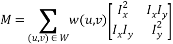

In [12]:
def get_M(I, grad, u, v):
  w = I.shape[0]
  h = I.shape[1]

  Icopy = np.zeros((w+4, h+4), dtype=int)
  Icopy[2:w+2, 2:h+2] = I

  M = np.zeros((2, 2), dtype=float)
  for i in range(u-2, u+3):
    for j in range(v-2, v+3):
      Ix = grad[i, j, 0]
      Iy = grad[i, j, 1]
      A = np.array([[Ix**2, Ix*Iy], [Ix*Iy, Iy**2]], dtype=float)
      A.shape = (2, 2)
      new = np.sum(W * Icopy[i-2+2:i+3+2, j-2+2:j+3+2]) * A
      M = np.add(M, new)
  return M

In [13]:
M = []
for p in F:
  x, y = p
  m = get_M(halftoneImage, grad, x, y)
  M.append(m)
print(M)

[array([[ 810055.43189206, -363540.69123432],
       [-363540.69123432,  438973.56964797]]), array([[ 729797.76660785, -302567.33978884],
       [-302567.33978884,  384988.4392989 ]]), array([[ 760931.59955019, -372466.94669853],
       [-372466.94669853,  478439.24329417]]), array([[527385.85646547, -55016.64341343],
       [-55016.64341343, 136680.69742159]]), array([[332667.00047265, -26481.18160324],
       [-26481.18160324, 126398.59781533]]), array([[3940705.29482769,  823870.80606406],
       [ 823870.80606406, 5001799.58884313]]), array([[3495167.36648038,  285250.5293769 ],
       [ 285250.5293769 , 4097490.86802987]]), array([[3847715.22134518, 1236627.92681332],
       [1236627.92681332, 3543212.2586003 ]]), array([[3931351.31850998,  794412.87414372],
       [ 794412.87414372, 6817864.39543442]]), array([[3483148.12102383,  290632.34250255],
       [ 290632.34250255, 5476511.40419816]]), array([[2693136.20796382,  766842.03200288],
       [ 766842.03200288, 8417325.65679195

На основе значения критерия R = det(M) - k*(tr(M))^2 принять решение о фильтрации ключевой точки. Параметр k выбрать из интервала [0.04, 0.06]. 

In [14]:
def get_R(m, k):
  r = np.linalg.det(m) - k * np.trace(m)**2
  return r

In [15]:
k = 0.04
R = []
for m in M:
  r = get_R(m, k)
  R.append(r)

print(R)

[161028152499.73578, 139706776668.07947, 163886308860.77985, 51417260099.84497, 32917740478.811867, 15833119274557.373, 11934110139236.465, 9918990749946.066, 21550502827211.65, 15780013296473.83, 17143263284555.23, 11640450804138.426, 5964493553040.74, 8334072621149.869, 9348583909874.826, 14382647731955.906, 13486063599028.906, 19358708248808.902, 10100110200464.955, 10438543396220.982, 14244621738224.186, 18982940827886.586, 16239384120394.037, 12378223576353.137, 11635381820487.332, 6190636883304.848, 391363064226.01636, 294578869863.4498, 383820547696.78436, 46988987458.075806, -813387006417.2668, -40057077656.52991, -1258976437116.1387, 9113286695703.584, -1665185464994.1348, 8123050443449.465, 13108056310618.836, 9305924592519.326, 13584621357327.684, 3652000860276.3135, 5020071027220.529, 22000053827.258263, 2397166289716.822, 10561207237528.406, 7830968759716.703, 6493740084387.643, 11282330972657.996, 5621803863726.478, 328050916124.56366, 749568527757.0603, 1456734756932.457

Отфильтровать точки по убыванию значения критерия Харриса и выбрать первые N точек.

In [18]:
N = len(F)//2
point_R = dict()
for i in range(len(F)):
  point_R[F[i]] = R[i]
  
points = list(dict(sorted(point_R.items(), key=lambda item: item[1], reverse=True)[0:N]).keys())
print(len(points), points)

36 [(62, 178), (72, 178), (75, 170), (63, 178), (76, 170), (61, 178), (62, 179), (71, 178), (73, 178), (94, 188), (72, 177), (93, 188), (76, 171), (61, 179), (63, 179), (77, 170), (104, 168), (103, 168), (73, 177), (72, 179), (62, 177), (71, 177), (94, 187), (92, 188), (65, 172), (93, 187), (103, 169), (104, 167), (81, 94), (64, 173), (116, 179), (105, 168), (96, 183), (115, 179), (117, 178), (95, 188)]


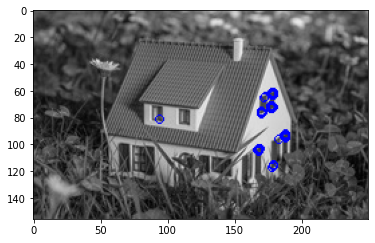

In [32]:
imageWithFeatures = np.zeros_like(image, dtype=int)
for i in range(w):
    for j in range(h):
        imageWithFeatures[i, j, :] = halftoneImage[i, j]

color = [0, 0, 255]
for i, j in points:
  imageWithFeatures[i-1:i+2, j-3] = color
  imageWithFeatures[i+2, j-2] = color
  imageWithFeatures[i+3, j-1:j+2] = color
  imageWithFeatures[i+2, j+2] = color
  imageWithFeatures[i-1:i+2, j+3] = color
  imageWithFeatures[i-2, j+2] = color
  imageWithFeatures[i-3, j-1:j+2] = color
  imageWithFeatures[i-2, j-2] = color

figure()
imshow(imageWithFeatures, vmin=0, vmax=255)
show()

# 2. Описание ключевых точек (построение дескриптора)

Для каждой оставшейся после фильтрации точки вычислить ориентацию на основе моментов изображения m01,m10:

angle = atan2(m01; m10).


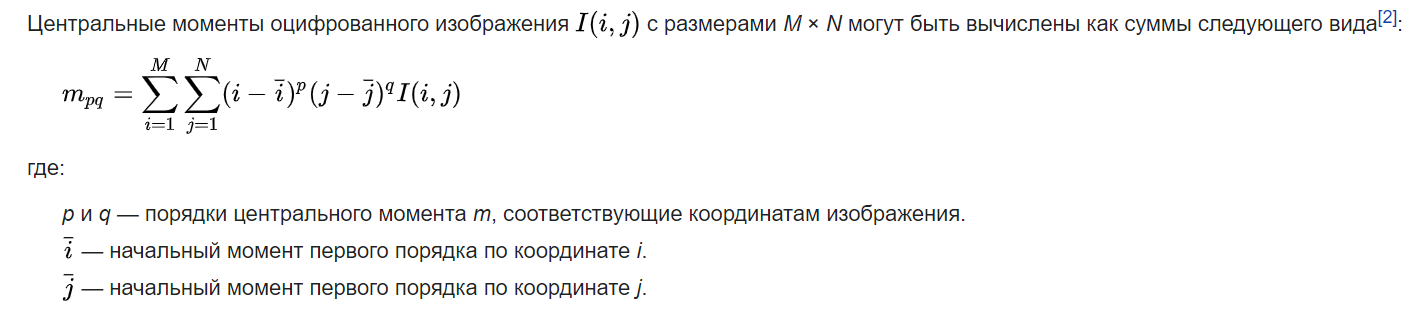

In [20]:
def get_moment(I, p, q, x, y, r):
  w = I.shape[0]
  h = I.shape[1]

  ci = w//2
  cj = h//2

  m = 0
  for i in range(max(0, x-r), min(w, x+r+1)):
      for j in range(max(0, y-r), min(h, y+r+1)):
        m += (i-ci)**p * (j-cj)**q * I[i, j]
  return m

In [21]:
import math

In [22]:
patch_size = 31
r = patch_size

angles = []
for x, y in points:
  m01 = get_moment(halftoneImage, 0, 1, x, y, r)
  m10 = get_moment(halftoneImage, 1, 0, x, y, r)
  a = math.atan2(m01, m10) % (2*np.pi)
  angles.append(a)

print(angles)

[1.8208408256375137, 1.647419662868959, 1.6029328057455838, 1.802312851139717, 1.5837000014650977, 1.839626553482187, 1.8175320915315207, 1.6638066307273025, 1.6307879948364477, 1.3279260015148233, 1.6488365310346105, 1.3417991887832312, 1.5833179361100926, 1.8361822937630685, 1.7991245004701677, 1.5643061869832255, 1.0902184964025534, 1.105131006775189, 1.6319362266514166, 1.646269451015837, 1.8240556468999964, 1.6654362352042762, 1.3243381332171245, 1.3562033140604504, 1.783372794490391, 1.3383913703800936, 1.110760761344341, 1.0841904767360442, 4.840281529831432, 1.799485233775021, 0.9834158293583705, 1.075039320759627, 1.2721649477041868, 0.996355333631163, 0.964526142234684, 1.314374137027384]


Перед построением дескриптора изображение необходимо сгладить с помощью фильтра Гаусса

In [23]:
def build_G(sigma2_e):
  const1 = 2*sigma2_e
  const2 = 2*np.pi*sigma2_e

  G = np.zeros(9, dtype=np.float64)
  G.shape = (3, 3)

  for i in range(3):
    for j in range(3):
      G[i, j] = np.power(np.e, -((i-3//2)**2 + (j-3//2)**2)/const1)/const2

  G /= np.sum(G)
  return G

G = build_G(100)
print(G)

def Gaussian_filtering(image_e):
  width_e = image_e.shape[0]
  height_e = image_e.shape[1]

  gaussImage = np.zeros(width_e*height_e, dtype=int)
  gaussImage.shape = (width_e, height_e)

  image_eCopy = np.zeros((width_e+1)*(height_e+1), dtype=int)
  image_eCopy.shape = ((width_e+1),(height_e+1))


  for i in range(width_e):
      for j in range(height_e):
        image_eCopy[i+1, j+1] = image_e[i, j]

  for i in range(1, width_e-1):
      for j in range(1, height_e-1):
        gaussImage[i, j] = np.sum(G * image_eCopy[i-1:i+2, j-1:j+2])

  gaussImage = clip(gaussImage, 0, 255)     
  return gaussImage 

[[0.11074074 0.11129583 0.11074074]
 [0.11129583 0.1118537  0.11129583]
 [0.11074074 0.11129583 0.11074074]]


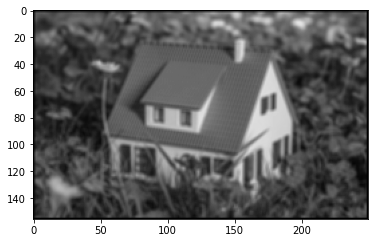

In [24]:
gaussImage = Gaussian_filtering(halftoneImage)
figure()
imshow(gaussImage, cmap='gray', vmin=0, vmax=255)

BRIEF представляет из себя бинарный вектор, каждый элемент которого получается из сравнения
интенсивностей пикселей из области вокруг особой точки.

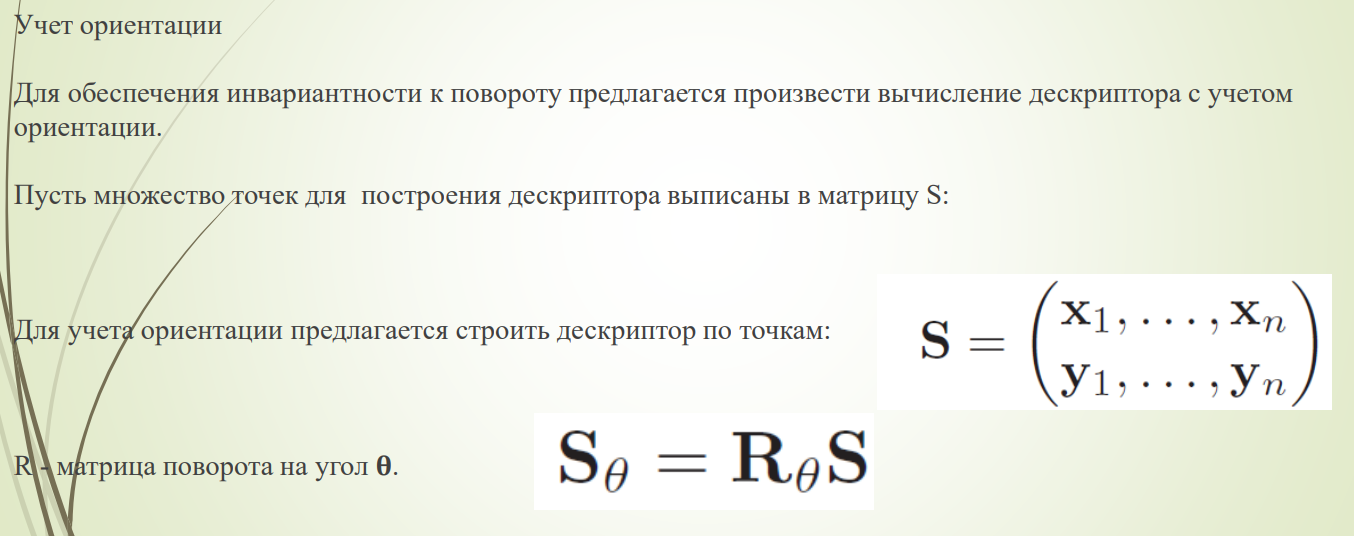

In [25]:
theta = [2*k*np.pi/30 for k in range(30)]
print(len(theta), theta)

30 [0.0, 0.20943951023931953, 0.41887902047863906, 0.6283185307179586, 0.8377580409572781, 1.0471975511965976, 1.2566370614359172, 1.4660765716752369, 1.6755160819145563, 1.8849555921538759, 2.0943951023931953, 2.3038346126325147, 2.5132741228718345, 2.7227136331111543, 2.9321531433504737, 3.1415926535897927, 3.3510321638291125, 3.5604716740684323, 3.7699111843077517, 3.979350694547071, 4.1887902047863905, 4.39822971502571, 4.607669225265029, 4.817108735504349, 5.026548245743669, 5.235987755982989, 5.445427266222309, 5.654866776461628, 5.8643062867009474, 6.073745796940267]


In [26]:
Rt = []
for t in theta:
  rt = np.array([[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])
  Rt.append(rt)

print(Rt)

[array([[ 1., -0.],
       [ 0.,  1.]]), array([[ 0.9781476 , -0.20791169],
       [ 0.20791169,  0.9781476 ]]), array([[ 0.91354546, -0.40673664],
       [ 0.40673664,  0.91354546]]), array([[ 0.80901699, -0.58778525],
       [ 0.58778525,  0.80901699]]), array([[ 0.66913061, -0.74314483],
       [ 0.74314483,  0.66913061]]), array([[ 0.5      , -0.8660254],
       [ 0.8660254,  0.5      ]]), array([[ 0.30901699, -0.95105652],
       [ 0.95105652,  0.30901699]]), array([[ 0.10452846, -0.9945219 ],
       [ 0.9945219 ,  0.10452846]]), array([[-0.10452846, -0.9945219 ],
       [ 0.9945219 , -0.10452846]]), array([[-0.30901699, -0.95105652],
       [ 0.95105652, -0.30901699]]), array([[-0.5      , -0.8660254],
       [ 0.8660254, -0.5      ]]), array([[-0.66913061, -0.74314483],
       [ 0.74314483, -0.66913061]]), array([[-0.80901699, -0.58778525],
       [ 0.58778525, -0.80901699]]), array([[-0.91354546, -0.40673664],
       [ 0.40673664, -0.91354546]]), array([[-0.9781476 , -0.2079116

In [27]:
n = 256 #длина дескриптора
S = (np.pi/5) * np.random.randn(n, 2, 2)
print(S)

[[[-0.73910916 -0.1804067 ]
  [-0.9880569  -0.30841587]]

 [[-0.52801866 -1.39100643]
  [ 0.8187133  -0.36915892]]

 [[-0.66809724 -0.32576099]
  [ 0.63207305 -0.1151091 ]]

 ...

 [[-0.08328576 -0.31194411]
  [-0.36452325 -0.19162995]]

 [[-0.73149937  0.18047306]
  [-0.558272    0.13978464]]

 [[-0.60959722  0.94772002]
  [ 0.01487861  1.04454285]]]


In [28]:
St = []
for rt in Rt:
  st = []
  for i in range(S.shape[0]):
    st.append([rt.dot(S[i, 0]), rt.dot(S[i, 1])])
  St.append(st)

print(St)

[[[array([-0.73910916, -0.1804067 ]), array([-0.9880569 , -0.30841587])], [array([-0.52801866, -1.39100643]), array([ 0.8187133 , -0.36915892])], [array([-0.66809724, -0.32576099]), array([ 0.63207305, -0.1151091 ])], [array([ 0.23313004, -0.4200504 ]), array([-0.24394435,  0.42031865])], [array([ 0.11302751, -0.75356902]), array([-1.08366972, -0.1357185 ])], [array([-0.30479923,  1.00296901]), array([-1.39118963, -1.03889022])], [array([-0.58136489,  0.10858477]), array([-0.76269679,  0.9446559 ])], [array([-0.4924492 ,  0.05255015]), array([ 0.16871426, -0.90263952])], [array([-0.48283166,  0.27688435]), array([1.29418821, 0.22691328])], [array([-0.04196554,  0.84401664]), array([-0.41176525, -0.51962425])], [array([ 0.40879248, -1.1590827 ]), array([ 0.01521401, -1.06443131])], [array([-0.37391903,  0.89108562]), array([-0.48245523,  1.21683708])], [array([-0.5575476 ,  0.51894674]), array([-0.758127  ,  0.77981932])], [array([0.15578149, 1.04627703]), array([0.59364646, 0.03032117]

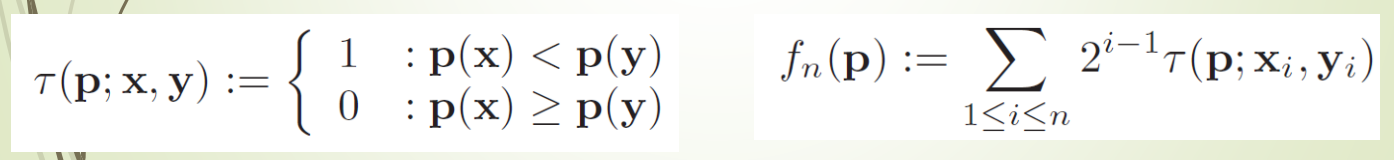

In [29]:
def tau(p, c, i, j):
  xi, yi = np.array((i * patch_size//2 + c), dtype=int)
  xj, yj = np.array((j * patch_size//2 + c), dtype=int)
  # print(xi, yi)
  # print(xj, yj)
  if p[xi, yi] < p[xj, yj]:
    return '1'
  return '0'

descriptor = dict()
for j in range(len(points)):
  c = points[j]
  #print("center: ", c[0], c[1])

  t = len(theta)-1
  for i in range(len(theta)):
    if angles[j] < theta[i]:
      t = i-1
      break
  s = St[t]

  f = ""
  for i in range(n-1, -1, -1):
    f += tau(gaussImage, c, S[i, 0], S[i, 1])
  descriptor[c] = f

In [30]:
f = open("descriptor.txt", "w")
for x, y in descriptor:
  line = "(" + str(x) + ", " + str(y) + "): " + str(descriptor[(x, y)]) + "\n"
  f.write(line)
f.close()

In [31]:
f = open("descriptor.txt", "r")
print(f.read())

(62, 178): 1100001011000010110001111010111000011010010010100111010010110010100100111101101100111000011000111111011010001100001110000111110000101110111001111110011000100011011110110100010010001101000110000111000001100100011010110100000001010000100101110010011100111000
(72, 178): 1011101001100011011100011010111100010001000010100001001000110010110000101101101001100100111001111001101111011000001000100101001101100110011001010000011011000011101011010100010001100110010000010110011001101111111100011100100001100110001110110010001110111010
(75, 170): 0011110001010110010000101100111100110001110000010100001110001111110010111110010011000100011111011101011110010010001010110100111000110101001000111111001100100111110001100100110001100111010111001010011000101010010101110000011010110111011111110011000101010110
(63, 178): 11000010110000101100011110101111000110000100101001110100101100101001001111011011001110000110001111110110100110000011111001111000001011101110011111100110101000110111101101000100100011010